In [272]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Basic Image Preprocessing

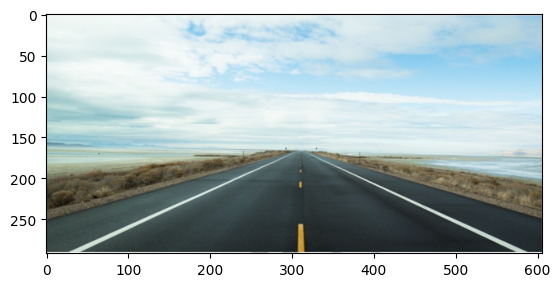

In [273]:
img = cv2.imread('images/img.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

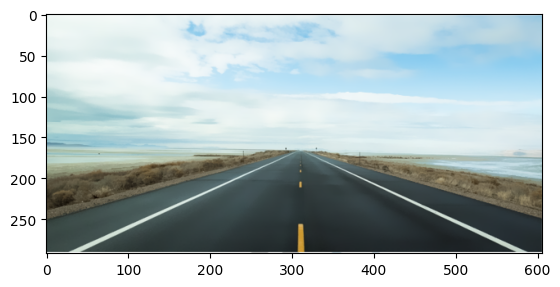

In [274]:
img = cv2.bilateralFilter(img,15,15,75) # Blurring Image to reduce noise
plt.imshow(img)

In [275]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #grayscale conversion

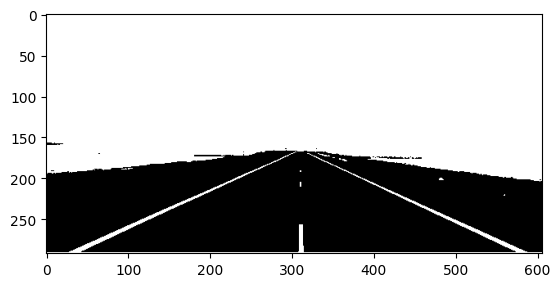

In [276]:
thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_OTSU)[1] # thresholding
plt.imshow(thresh, cmap='gray')

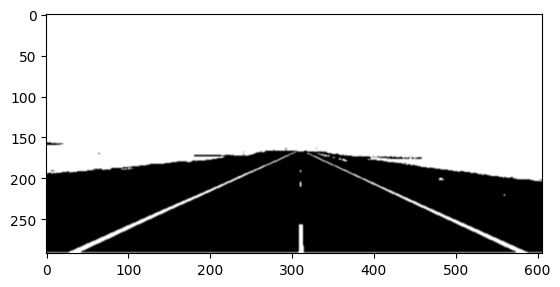

In [277]:
bthresh = cv2.GaussianBlur(thresh, (3, 3), 0)
plt.imshow(bthresh, cmap='gray')

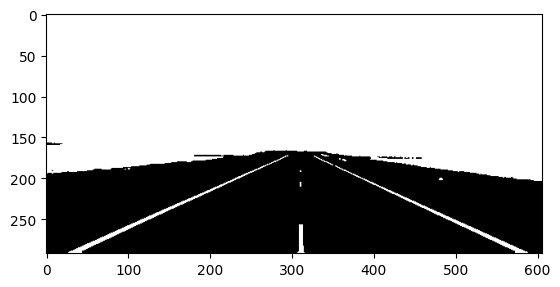

In [278]:
dthresh = cv2.threshold(bthresh, 127, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
plt.imshow(dthresh, cmap='gray') # first thresholded image

**Creating Yellow Mask**

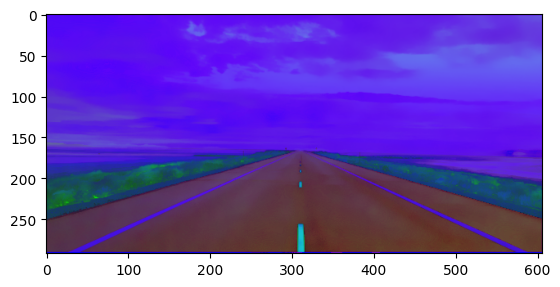

In [279]:
lower_yellow = np.array([15, 100, 100], dtype=np.uint8)
upper_yellow = np.array([35, 255, 255], dtype=np.uint8)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
plt.imshow(hsv)

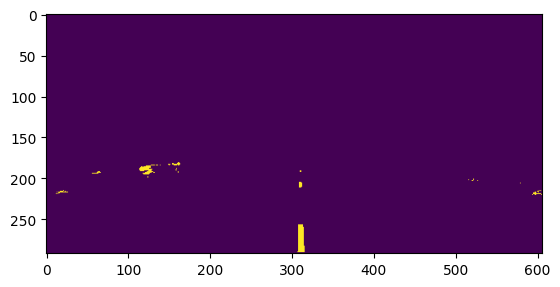

In [280]:
plt.imshow(yellow)

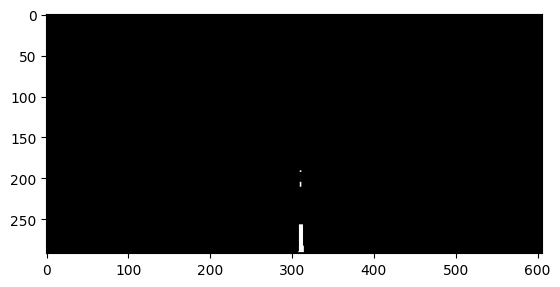

In [281]:
yellow_mask = cv2.bitwise_and(yellow, yellow, mask=dthresh) 
plt.imshow(yellow_mask, cmap='gray')
yellow_mask_inv = cv2.bitwise_not(yellow_mask)

**Creating White Mask**

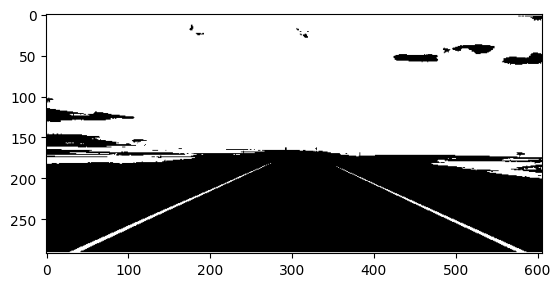

In [282]:
bright = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY)[1]
plt.imshow(bright, cmap='gray')

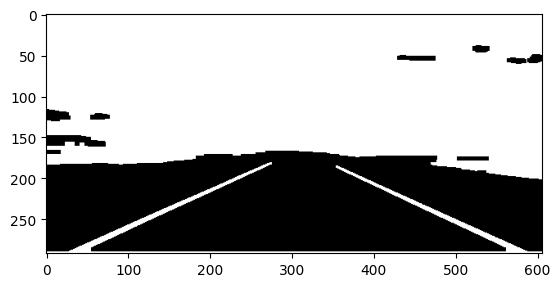

In [283]:
bright = cv2.dilate(bright, None, iterations=3)
bright = cv2.erode(bright, None, iterations=2) # to smoothen the boundaries
plt.imshow(bright, cmap='gray') # second thresholded image

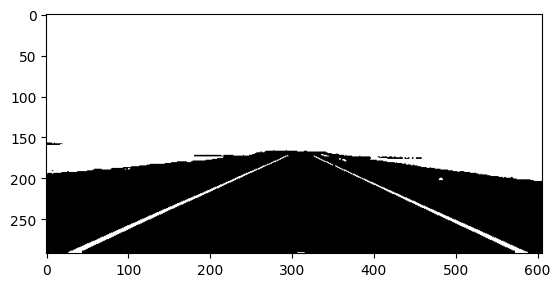

In [284]:
dthresh = cv2.bitwise_and(yellow_mask_inv, dthresh) #removing yellow part
plt.imshow(dthresh, cmap='gray')

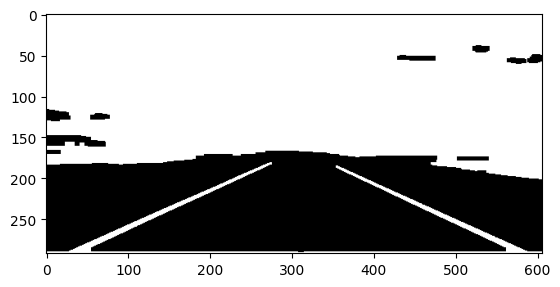

In [285]:
bright = cv2.bitwise_and(bright, yellow_mask_inv)
plt.imshow(bright, cmap='gray')

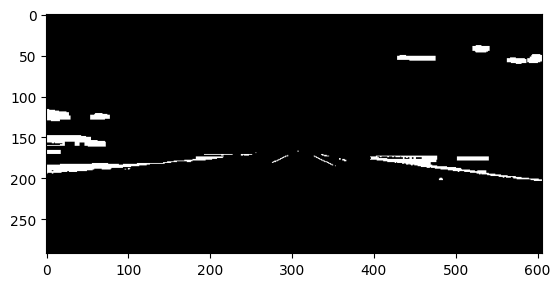

In [286]:
bright_inv = cv2.bitwise_not(bright)
d_region = cv2.bitwise_and(dthresh, bright_inv) # region having noise due to environment
plt.imshow(d_region, cmap='gray')

In [287]:
def remove_noise(image):
    # Applied morphological opening (erosion followed by dilation)
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)

    # Finding contours and removing small areas
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 50:
            cv2.drawContours(cleaned, [cnt], -1, 0, -1)  # Filling small noise with black

    return cleaned

In [288]:
def getHoughLines(thresh_img):
    edges = cv2.Canny(thresh_img, 100, 150) # canny edge detection

    # Finding contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Creating a mask
    mask = np.ones_like(thresh_img) * 255

    # Filtering contours based on Y-coordinate (removing those near the top)
    for cnt in contours:
        if cv2.boundingRect(cnt)[1] < 50:  # Remove contours in the upper 50 pixels
            cv2.drawContours(mask, [cnt], -1, (0,), thickness=cv2.FILLED)

    # Applying mask to remove unwanted edges
    filtered_edges = cv2.bitwise_and(edges, edges, mask=mask)
    mask_d = np.zeros_like(filtered_edges)
    lines = cv2.HoughLinesP(filtered_edges, 1, np.pi / 180, 68, minLineLength=50, maxLineGap=250)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask_d, (x1, y1), (x2, y2), (255, 255, 255), 2)
    return mask_d

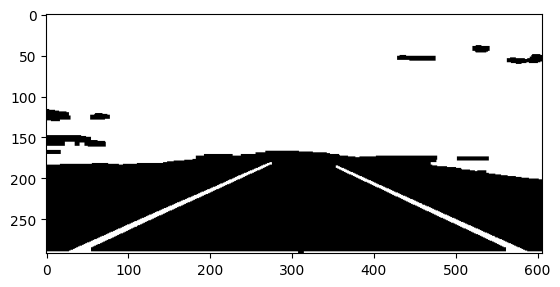

In [289]:
bright = remove_noise(bright)
plt.imshow(bright, cmap='gray')

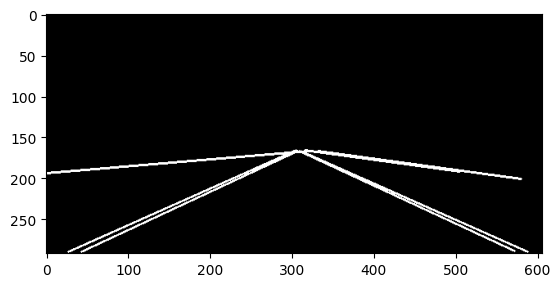

In [290]:
h_d = getHoughLines(dthresh)
h_b = getHoughLines(bright) # lines of thresholded images
plt.imshow(h_d, cmap='gray')

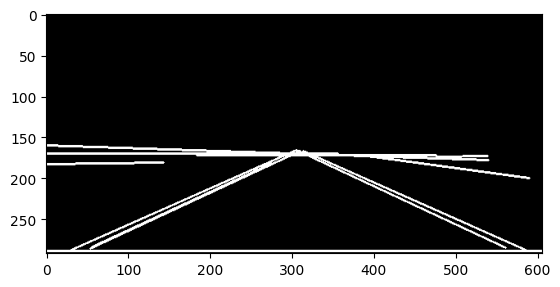

In [291]:
plt.imshow(h_b, cmap='gray')

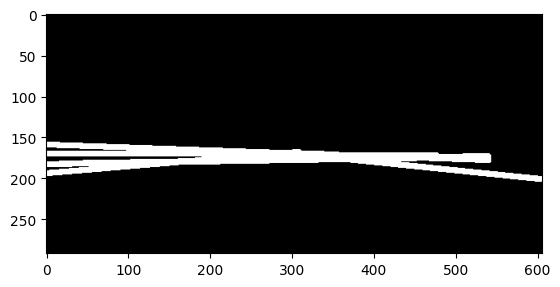

In [292]:
h_r = getHoughLines(d_region) #unwanted lines
h_r = cv2.dilate(h_r, None, iterations=2)
plt.imshow(h_r, cmap='gray')

In [293]:
#bitwise operations to get mask
white_mask = cv2.bitwise_and(h_d, cv2.bitwise_not(d_region))
white_mask = cv2.bitwise_and(white_mask, cv2.bitwise_not(h_r))
white_mask = cv2.bitwise_and(white_mask, h_b)

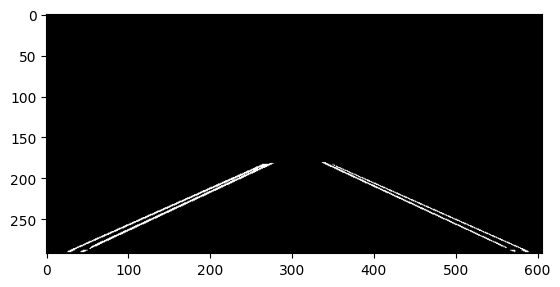

In [294]:
plt.imshow(white_mask, cmap='gray')

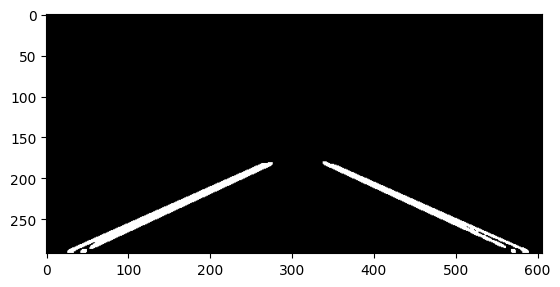

In [295]:
#removing noise from mask
white_mask_d = cv2.GaussianBlur(white_mask, (9, 9), 0)
white_mask_d = cv2.threshold(white_mask_d, 127, 255, cv2.THRESH_OTSU)[1]
plt.imshow(white_mask_d, cmap='gray')

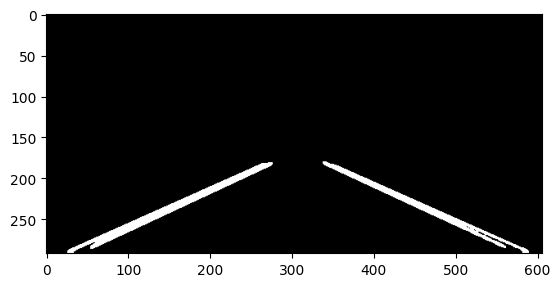

In [296]:
white_mask_f = remove_noise(white_mask_d)
plt.imshow(white_mask_f, cmap='gray')

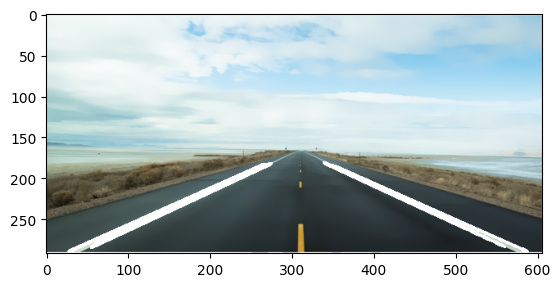

In [297]:
overlap_arr = np.where(white_mask_f > gray)
overlap_w = img.copy()
overlap_w[overlap_arr] = 255
plt.imshow(overlap_w)

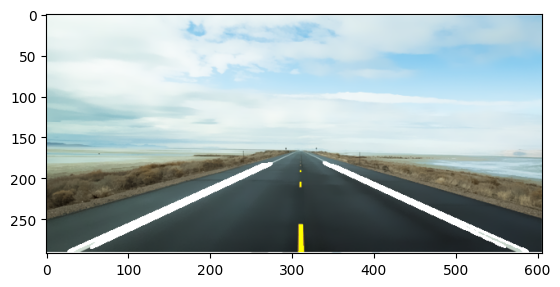

In [298]:
overlap_arr_y = np.where(yellow_mask > 0)
overlap_w_y = overlap_w.copy()
overlap_w_y[overlap_arr_y] = [255, 255, 0]
plt.imshow(overlap_w_y)
overlap_w_y = cv2.cvtColor(overlap_w_y, cv2.COLOR_RGB2BGR)

Saving Submission Images

In [299]:
yellow_mask_final = np.zeros_like(img)
yellow_mask_final[overlap_arr_y] = [0 ,255, 255]
cv2.imwrite('./images/yellow_mask.png', yellow_mask_final)

True

In [300]:
cv2.imwrite('./images/white_mask.png', white_mask_f)

True

In [301]:
cv2.imwrite('./images/processed.png', overlap_w_y)

True